In [1]:
%run ./check_DOVS_METHODS.ipynb

In [2]:
from importlib import reload
#reload(Utilities)
#reload(clm)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns
from packaging import version

import copy

import itertools

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
from Utilities_df import DFConstructType
import Plot_General
import Plot_Box_sns
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer

In [29]:
fig_num=0

In [67]:
save_dir = r'C:\Users\s346557\Documents\Presentations\DOVS_check\_DemoFigs'
save_figs = True

In [30]:
starttimeperiod_local = pd.date_range(
    start = '2023-01-01 13:00:00', 
    end   = '2023-01-01 17:00:00', 
    freq  = '15T'
)
zeros_t_beg = pd.to_datetime('2023-01-01 14:00:00')
zeros_t_end = pd.to_datetime('2023-01-01 16:00:00')
#-------------------------
value = [245]*len(starttimeperiod_local)
serialnumber = ['SN']*len(starttimeperiod_local)
#-------------------------
ami_df = pd.DataFrame(
    data={
        'starttimeperiod_local':starttimeperiod_local, 
        'value':value, 
        'serialnumber':serialnumber
    }
)
#-----
ami_df.loc[
    (ami_df['starttimeperiod_local']>=zeros_t_beg) & 
    (ami_df['starttimeperiod_local']<=zeros_t_end), 
    'value'
]=0

In [45]:
best_ests_df = pd.DataFrame(data=dict(
    conservative_min = [pd.to_datetime('2023-01-01 13:45:00')], 
    zero_times_min   = [pd.to_datetime('2023-01-01 14:00:00')], 
    zero_times_max   = [pd.to_datetime('2023-01-01 16:15:00')], 
    conservative_max = [pd.to_datetime('2023-01-01 16:30:00')]
))
best_ests_df

,conservative_min,zero_times_min,zero_times_max,conservative_max
0,2023-01-01 13:45:00,2023-01-01 14:00:00,2023-01-01 16:15:00,2023-01-01 16:30:00


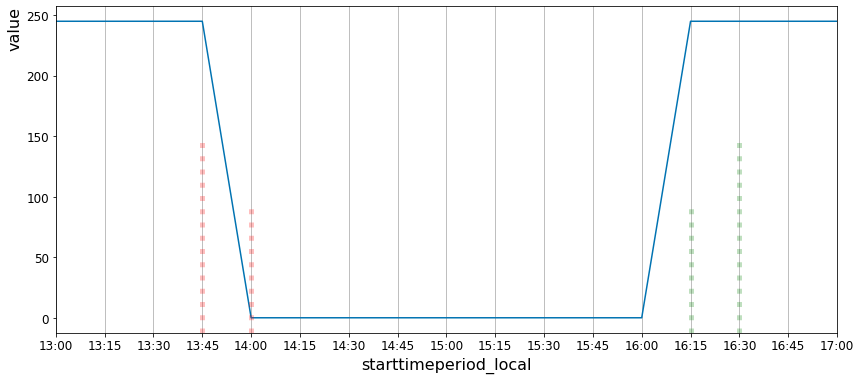

In [91]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)

fig, ax = AMINonVee.plot_usage(
    fig=fig, 
    ax=ax, 
    data=ami_df, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
)
ax.legend().set_visible(False)
ax.set_xlim(ami_df.iloc[0]['starttimeperiod_local'], ami_df.iloc[-1]['starttimeperiod_local'])
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) 
ax.grid(axis='x', which='both')
add_all_best_ests_to_axis(
    ax, 
    best_ests_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['conservative', 'zero_times']
)
#-----
Plot_General.set_general_plotting_args(
    ax=ax, 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=12.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=12.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=ax.get_xlabel(), fontsize=16, loc='center'), 
    ylabel_args=dict(ylabel=ax.get_ylabel(), fontsize=16, loc='top')
)
#-----
if save_figs:
    Plot_General.save_fig(
        fig=fig, 
        save_dir=save_dir, 
        save_name='UncertaintyIntervals.png'
    )
#-----
fig_num+=1

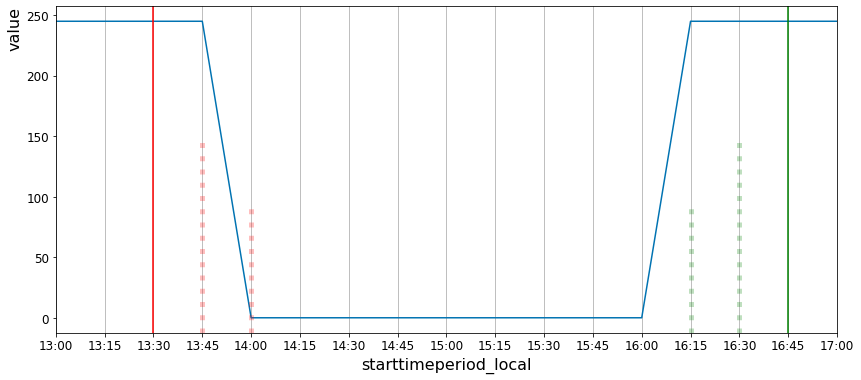

In [103]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)
#-------------------------
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=pd.to_datetime('2023-01-01 13:30:00'), 
    out_t_end=pd.to_datetime('2023-01-01 16:45:00'), 
    expand_time=pd.Timedelta('120 hours'), 
)
ax.legend().set_visible(False)
ax.set_xlim(ami_df.iloc[0]['starttimeperiod_local'], ami_df.iloc[-1]['starttimeperiod_local'])
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) 
ax.grid(axis='x', which='both')
add_all_best_ests_to_axis(
    ax, 
    best_ests_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['conservative', 'zero_times']
)
#-----
Plot_General.set_general_plotting_args(
    ax=ax, 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=12.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=12.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=ax.get_xlabel(), fontsize=16, loc='center'), 
    ylabel_args=dict(ylabel=ax.get_ylabel(), fontsize=16, loc='top')
)
#-----
if save_figs:
    Plot_General.save_fig(
        fig=fig, 
        save_dir=save_dir, 
        save_name='Audit_1.png'
    )
#-----
fig_num+=1

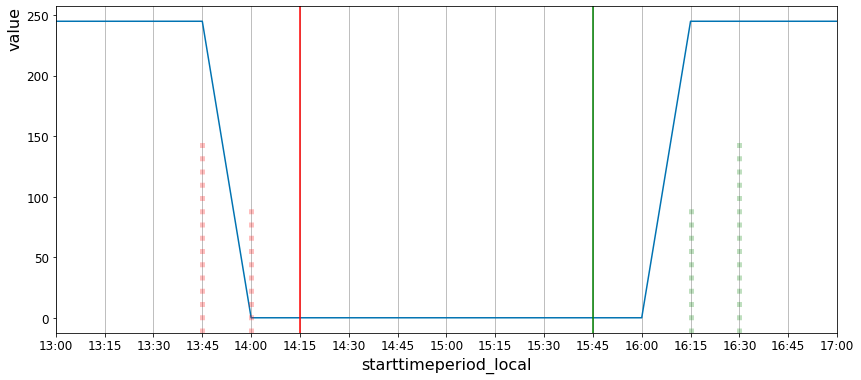

In [104]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)
#-------------------------
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=pd.to_datetime('2023-01-01 14:15:00'), 
    out_t_end=pd.to_datetime('2023-01-01 15:45:00'), 
    expand_time=pd.Timedelta('120 hours'), 
)
ax.legend().set_visible(False)
ax.set_xlim(ami_df.iloc[0]['starttimeperiod_local'], ami_df.iloc[-1]['starttimeperiod_local'])
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) 
ax.grid(axis='x', which='both')
add_all_best_ests_to_axis(
    ax, 
    best_ests_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['conservative', 'zero_times']
)
#-----
Plot_General.set_general_plotting_args(
    ax=ax, 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=12.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=12.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=ax.get_xlabel(), fontsize=16, loc='center'), 
    ylabel_args=dict(ylabel=ax.get_ylabel(), fontsize=16, loc='top')
)
#-----
if save_figs:
    Plot_General.save_fig(
        fig=fig, 
        save_dir=save_dir, 
        save_name='Audit_2.png'
    )
#-----
fig_num+=1

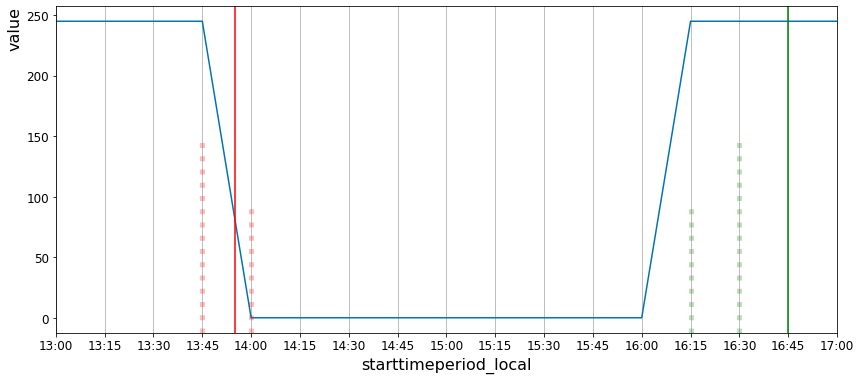

In [105]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)
#-------------------------
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=pd.to_datetime('2023-01-01 13:55:00'), 
    out_t_end=pd.to_datetime('2023-01-01 16:45:00'), 
    expand_time=pd.Timedelta('120 hours'), 
)
ax.legend().set_visible(False)
ax.set_xlim(ami_df.iloc[0]['starttimeperiod_local'], ami_df.iloc[-1]['starttimeperiod_local'])
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) 
ax.grid(axis='x', which='both')
add_all_best_ests_to_axis(
    ax, 
    best_ests_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['conservative', 'zero_times']
)
#-----
Plot_General.set_general_plotting_args(
    ax=ax, 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=12.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=12.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=ax.get_xlabel(), fontsize=16, loc='center'), 
    ylabel_args=dict(ylabel=ax.get_ylabel(), fontsize=16, loc='top')
)
#-----
if save_figs:
    Plot_General.save_fig(
        fig=fig, 
        save_dir=save_dir, 
        save_name='Audit_3.png'
    )
#-----
fig_num+=1

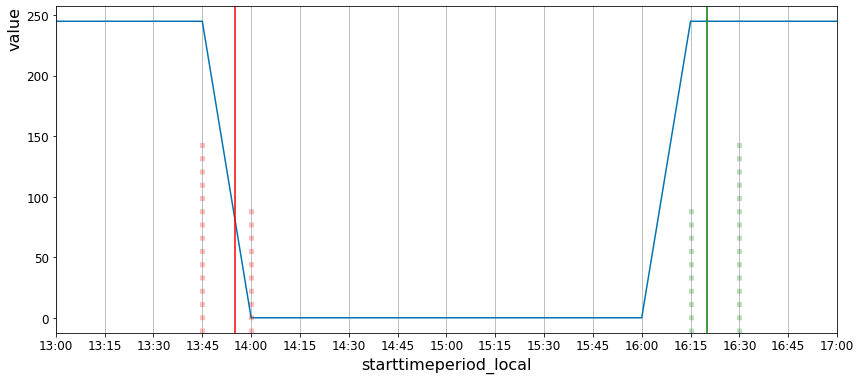

In [106]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)
#-------------------------
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=pd.to_datetime('2023-01-01 13:55:00'), 
    out_t_end=pd.to_datetime('2023-01-01 16:20:00'), 
    expand_time=pd.Timedelta('120 hours'), 
)
ax.legend().set_visible(False)
ax.set_xlim(ami_df.iloc[0]['starttimeperiod_local'], ami_df.iloc[-1]['starttimeperiod_local'])
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) 
ax.grid(axis='x', which='both')
add_all_best_ests_to_axis(
    ax, 
    best_ests_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['conservative', 'zero_times']
)
#-----
Plot_General.set_general_plotting_args(
    ax=ax, 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=12.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=12.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=ax.get_xlabel(), fontsize=16, loc='center'), 
    ylabel_args=dict(ylabel=ax.get_ylabel(), fontsize=16, loc='top')
)
#-----
if save_figs:
    Plot_General.save_fig(
        fig=fig, 
        save_dir=save_dir, 
        save_name='Audit_4.png'
    )
#-----
fig_num+=1

In [112]:
starttimeperiod_local = pd.date_range(
    start = '2023-01-01 13:00:00', 
    end   = '2023-01-01 17:00:00', 
    freq  = '15T'
)
zeros_t_beg = pd.to_datetime('2023-01-01 14:00:00')
zeros_t_end = pd.to_datetime('2023-01-01 16:00:00')
#-------------------------
value = [245]*len(starttimeperiod_local)
serialnumber = ['SN']*len(starttimeperiod_local)
#-------------------------
ami_df_2 = pd.DataFrame(
    data={
        'starttimeperiod_local':starttimeperiod_local, 
        'value':value, 
        'serialnumber':serialnumber
    }
)
#-----
ami_df_2.loc[
    (ami_df_2['starttimeperiod_local']>=zeros_t_beg) & 
    (ami_df_2['starttimeperiod_local']<=zeros_t_end), 
    'value'
]=0
ami_df_2.loc[ami_df_2['starttimeperiod_local']==pd.to_datetime('2023-01-01 15:00:00'), 'value']=245

In [129]:
best_ests_df_2 = pd.DataFrame(data=dict(
    conservative_min = [pd.to_datetime('2023-01-01 13:45:00'), pd.to_datetime('2023-01-01 15:01:00')], 
    zero_times_min   = [pd.to_datetime('2023-01-01 14:00:00'), pd.to_datetime('2023-01-01 15:16:00')], 
    zero_times_max   = [pd.to_datetime('2023-01-01 14:59:00'), pd.to_datetime('2023-01-01 16:15:00')], 
    conservative_max = [pd.to_datetime('2023-01-01 15:14:00'), pd.to_datetime('2023-01-01 16:30:00')]
))
best_ests_df_2

,conservative_min,zero_times_min,zero_times_max,conservative_max
0,2023-01-01 13:45:00,2023-01-01 14:00:00,2023-01-01 14:59:00,2023-01-01 15:14:00
1,2023-01-01 15:01:00,2023-01-01 15:16:00,2023-01-01 16:15:00,2023-01-01 16:30:00


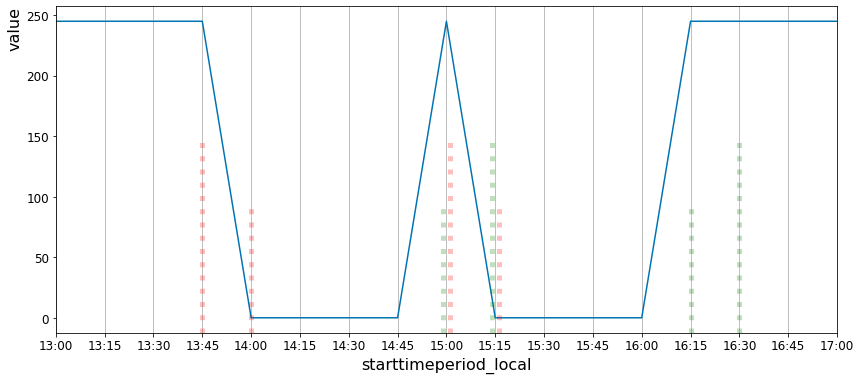

In [130]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)

fig, ax = AMINonVee.plot_usage(
    fig=fig, 
    ax=ax, 
    data=ami_df_2, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
)
ax.legend().set_visible(False)
ax.set_xlim(ami_df_2.iloc[0]['starttimeperiod_local'], ami_df_2.iloc[-1]['starttimeperiod_local'])
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) 
ax.grid(axis='x', which='both')
add_all_best_ests_to_axis(
    ax, 
    best_ests_df_2, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['conservative', 'zero_times']
)
#-----
Plot_General.set_general_plotting_args(
    ax=ax, 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=12.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=12.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=ax.get_xlabel(), fontsize=16, loc='center'), 
    ylabel_args=dict(ylabel=ax.get_ylabel(), fontsize=16, loc='top')
)
#-----
# if save_figs:
#     Plot_General.save_fig(
#         fig=fig, 
#         save_dir=save_dir, 
#         save_name='UncertaintyIntervals.png'
#     )
#-----
fig_num+=1

In [136]:
starttimeperiod_local = pd.date_range(
    start = '2023-01-01 13:15:00', 
    end   = '2023-01-01 14:45:00', 
    freq  = '15T'
)
zeros_t_beg = pd.to_datetime('2023-01-01 14:00:00')
zeros_t_end = pd.to_datetime('2023-01-01 14:00:00')
#-------------------------
value = [245]*len(starttimeperiod_local)
serialnumber = ['SN']*len(starttimeperiod_local)
#-------------------------
ami_df_3 = pd.DataFrame(
    data={
        'starttimeperiod_local':starttimeperiod_local, 
        'value':value, 
        'serialnumber':serialnumber
    }
)
#-----
ami_df_3.loc[
    (ami_df_3['starttimeperiod_local']>=zeros_t_beg) & 
    (ami_df_3['starttimeperiod_local']<=zeros_t_end), 
    'value'
]=0
ami_df_3.loc[ami_df_3['starttimeperiod_local']==pd.to_datetime('2023-01-01 15:00:00'), 'value']=245

In [138]:
best_ests_df_3 = pd.DataFrame(data=dict(
    conservative_min = [pd.to_datetime('2023-01-01 13:45:00')], 
    zero_times_min   = [pd.to_datetime('2023-01-01 14:00:00')], 
    zero_times_max   = [pd.to_datetime('2023-01-01 14:15:00')], 
    conservative_max = [pd.to_datetime('2023-01-01 14:30:00')]
))
best_ests_df_3

,conservative_min,zero_times_min,zero_times_max,conservative_max
0,2023-01-01 13:45:00,2023-01-01 14:00:00,2023-01-01 14:15:00,2023-01-01 14:30:00


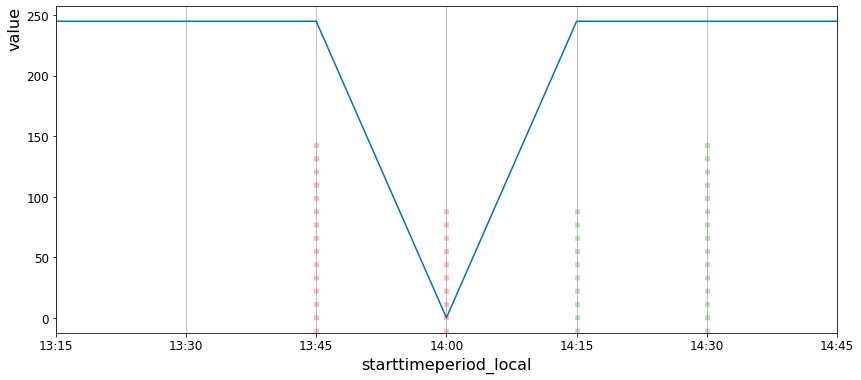

In [140]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)

fig, ax = AMINonVee.plot_usage(
    fig=fig, 
    ax=ax, 
    data=ami_df_3, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
)
ax.legend().set_visible(False)
ax.set_xlim(ami_df_3.iloc[0]['starttimeperiod_local'], ami_df_3.iloc[-1]['starttimeperiod_local'])
ax.xaxis.set_major_locator(dates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) 
ax.grid(axis='x', which='both')
add_all_best_ests_to_axis(
    ax, 
    best_ests_df_3, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['conservative', 'zero_times']
)
#-----
Plot_General.set_general_plotting_args(
    ax=ax, 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=12.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=12.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=ax.get_xlabel(), fontsize=16, loc='center'), 
    ylabel_args=dict(ylabel=ax.get_ylabel(), fontsize=16, loc='top')
)
#-----
# if save_figs:
#     Plot_General.save_fig(
#         fig=fig, 
#         save_dir=save_dir, 
#         save_name='UncertaintyIntervals.png'
#     )
#-----
fig_num+=1